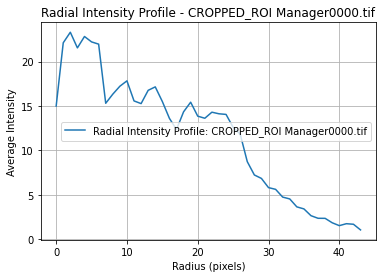

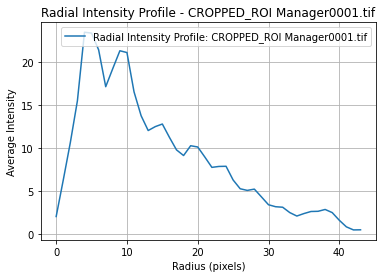

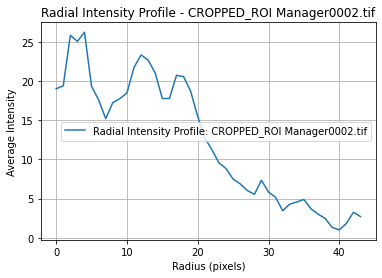

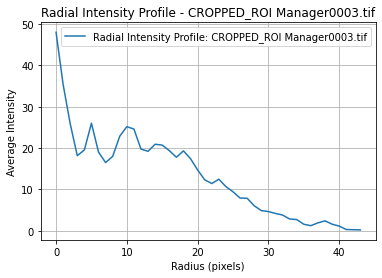

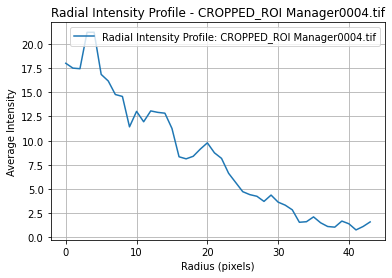

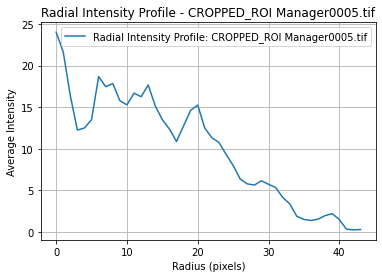

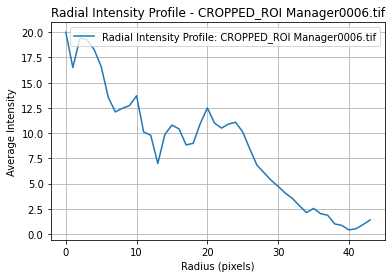

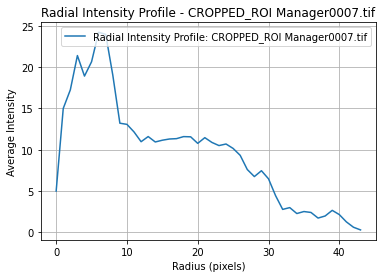

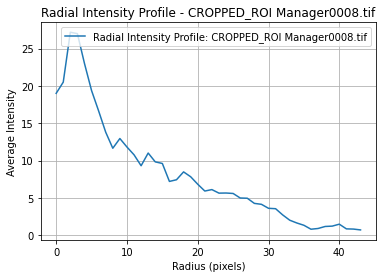

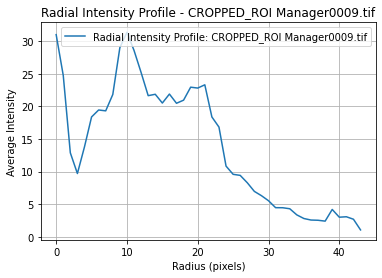

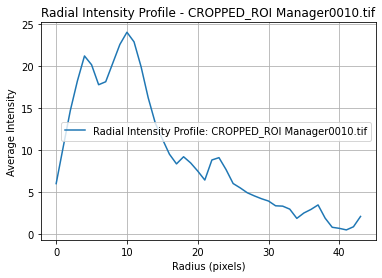

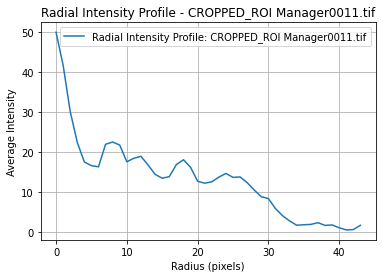

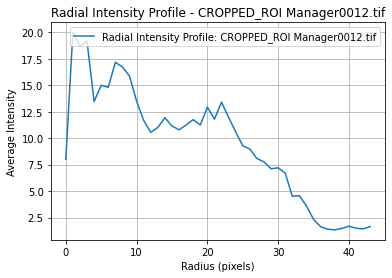

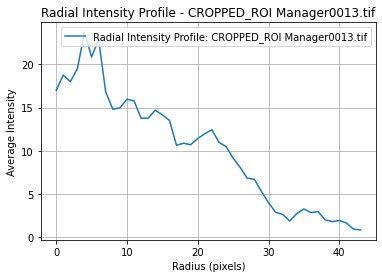

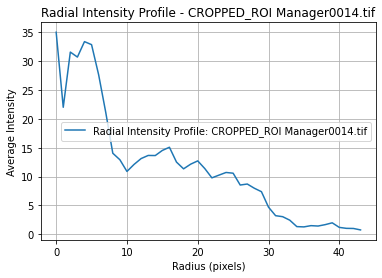

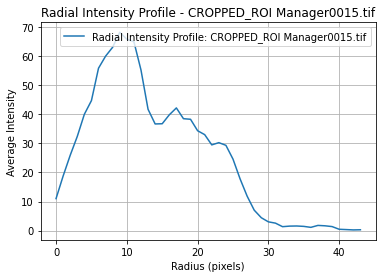

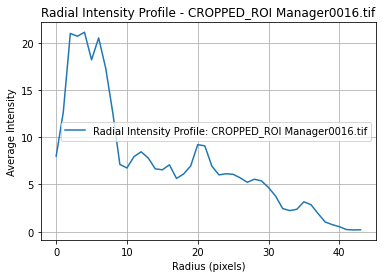

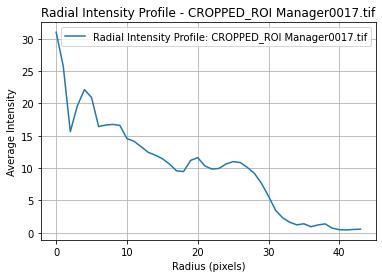

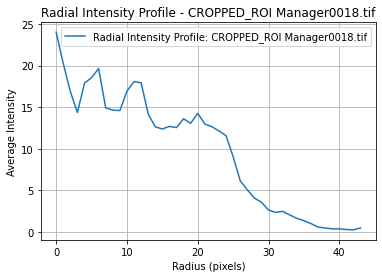

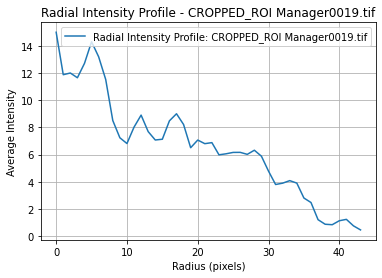

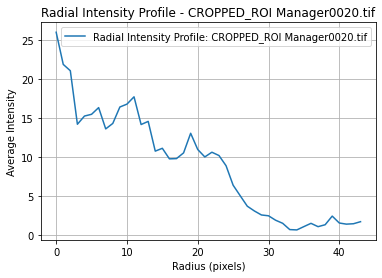

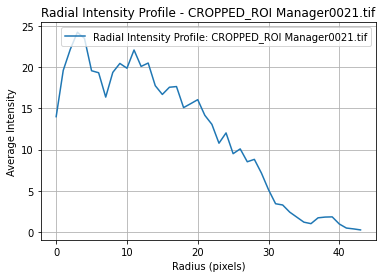

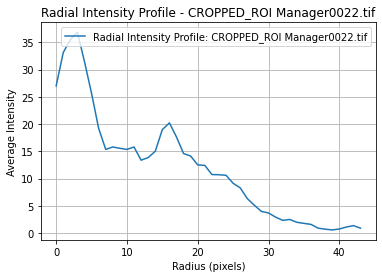

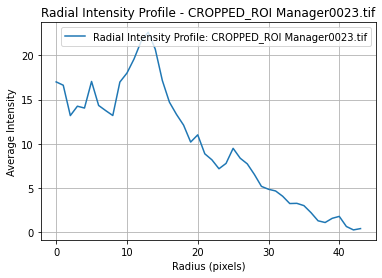

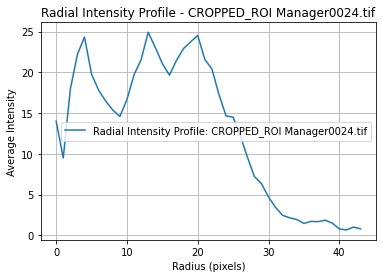

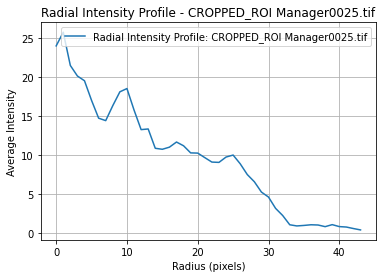

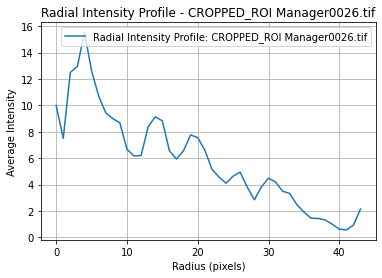

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def radial_intensity_profile(image_path):
    # Open the image and convert it to grayscale
    image = Image.open(image_path).convert("L")
    np_image = np.array(image)
    
    # Get image dimensions
    height, width = np_image.shape
    
    # Find the center of the image
    center_x, center_y = width // 2, height // 2
    
    # Create an array to hold the sum of pixel intensities and a count of how many pixels fall into each radius
    max_radius = int(np.hypot(center_x, center_y))
    radial_sum = np.zeros(max_radius)
    radial_count = np.zeros(max_radius)
    
    # Loop over each pixel and calculate its distance from the center
    for y in range(height):
        for x in range(width):
            # Calculate distance from the center
            radius = int(np.hypot(x - center_x, y - center_y))
            
            if radius < max_radius:
                # Add the pixel intensity to the corresponding radius
                radial_sum[radius] += np_image[y, x]
                radial_count[radius] += 1
    
    # Avoid division by zero for empty radius bins
    radial_count[radial_count == 0] = 1
    
    # Compute the average intensity for each radius
    radial_profile = radial_sum / radial_count
    
    return radial_profile

def plot_radial_profile(profile, image_name):
    plt.figure(figsize=(6, 4))
    plt.plot(profile, label=f'Radial Intensity Profile: {image_name}')
    plt.xlabel('Radius (pixels)')
    plt.ylabel('Average Intensity')
    plt.title(f'Radial Intensity Profile - {image_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def process_tiff_files(directory):
    # Process all TIFF files in the given directory
    for filename in os.listdir(directory):
        if filename.endswith(".tiff") or filename.endswith(".tif"):
            image_path = os.path.join(directory, filename)
            radial_profile = radial_intensity_profile(image_path)
            plot_radial_profile(radial_profile, filename)

# Example usage
tiff_directory = r'C:\Users\sqjac\OneDrive\Desktop\slices\cropped d2\d210c2'
process_tiff_files(tiff_directory)


Number of detected ROIs: 80


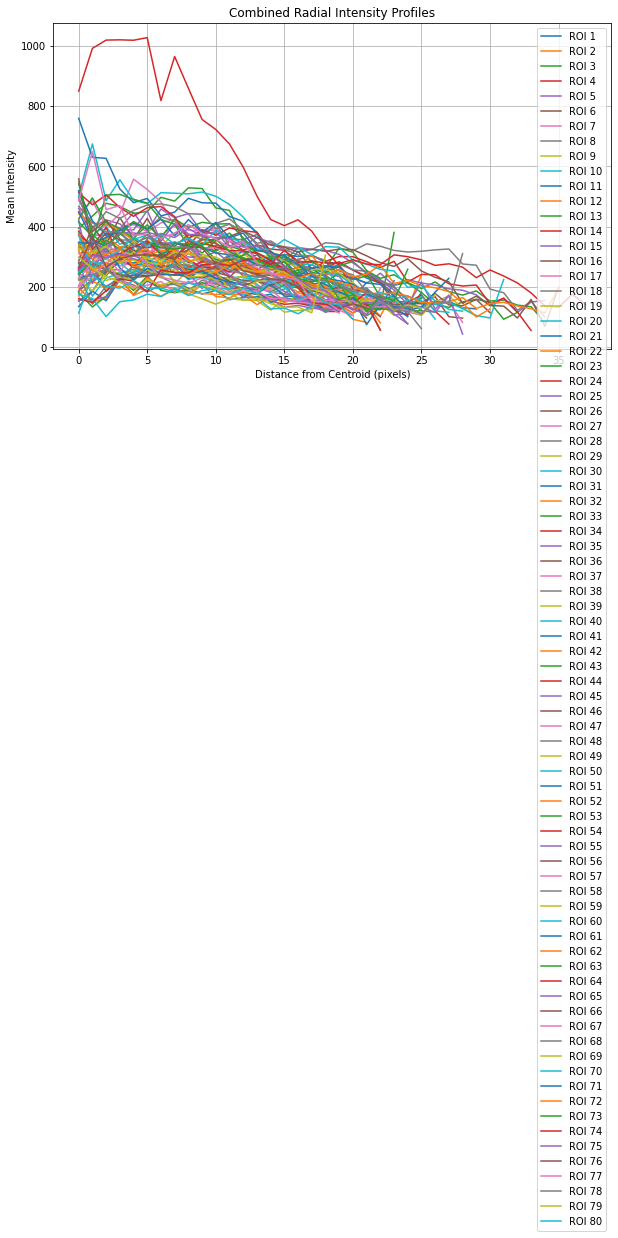

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from skimage import measure

def calculate_radial_profile(image, roi_mask):
    """ Calculate the radial intensity profile for each ROI in the mask. """
    labeled_rois = measure.label(roi_mask)
    num_rois = np.max(labeled_rois)
    
    print(f"Number of detected ROIs: {num_rois}")  

    radial_profiles = {}

    # Convert image to grayscale if it's multi-channel (e.g., RGB)
    if image.ndim == 3:
        image = np.mean(image, axis=2)  # Average across the color channels

    # Iterate through each ROI
    for roi in range(1, num_rois + 1):
        current_roi_mask = (labeled_rois == roi)
        coords = np.column_stack(np.where(current_roi_mask))

        if len(coords) == 0:
            print(f"ROI {roi} is empty.")  # Debugging output
            continue

        centroid = np.mean(coords, axis=0)
        distances = np.sqrt((coords[:, 0] - centroid[0]) ** 2 + (coords[:, 1] - centroid[1]) ** 2)

        max_distance = int(np.ceil(np.max(distances)))
        radial_profile = np.zeros(max_distance)
        radial_count = np.zeros(max_distance)

        for i in range(len(coords)):
            distance_bin = int(np.floor(distances[i]))
            if distance_bin < max_distance:
                radial_profile[distance_bin] += image[coords[i, 0], coords[i, 1]]
                radial_count[distance_bin] += 1

        # Avoid division by zero
        radial_profile /= radial_count
        radial_profile[np.isnan(radial_profile)] = 0

        # Store the radial profile
        radial_profiles[roi] = radial_profile

    return radial_profiles

def plot_combined_radial_profiles(radial_profiles):
    """ Plot all radial intensity profiles on the same figure. """
    plt.figure(figsize=(10, 6))
    
    for roi, profile in radial_profiles.items():
        plt.plot(profile, label=f'ROI {roi}')

    plt.title('Combined Radial Intensity Profiles')
    plt.xlabel('Distance from Centroid (pixels)')
    plt.ylabel('Mean Intensity')
    plt.legend()
    plt.grid()
    plt.show()

def plot_separate_radial_profiles(radial_profiles):
    """ Plot each radial intensity profile in separate figures. """
    for roi, profile in radial_profiles.items():
        plt.figure()
        plt.plot(profile)
        plt.title(f'Radial Intensity Profile for ROI {roi}')
        plt.xlabel('Distance from Centroid (pixels)')
        plt.ylabel('Mean Intensity')
        plt.grid()
        plt.show()



# Example Usage
if __name__ == "__main__":
    # Path to your flattened ROI TIFF image
    tiff_image_path = r'C:\Users\sqjac\OneDrive\Desktop\slices\flattened ROI masks\d110a1.tif'

    # Load the flattened ROI image
    roi_mask = imread(tiff_image_path)

    # If the ROI mask is binary, make sure to convert it to a boolean mask
    roi_mask = roi_mask > 0

    # Load the original image for intensity values (if different)
    original_image = imread(r'C:\Users\sqjac\OneDrive\Desktop\slices\slices\C2-D1_10k_A_1-0003.tif')

    # Calculate the radial intensity profiles
    radial_profiles = calculate_radial_profile(original_image, roi_mask)

    # Option 1: Plot combined radial profiles
    plot_combined_radial_profiles(radial_profiles)

    #Option 2: Plot separate radial profiles
    #plot_separate_radial_profiles(radial_profiles)  # Uncomment to use this option